In [194]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import numpy.linalg as npl
import scipy.linalg as spl
import pandas as pd
from numpy.fft import fft, ifft, fft2
from matplotlib import pyplot as plt
from pprint import pprint
from matrix_splitting import get_N, circ_first_col, circ_base_norm, circ_max, circ_min


In [209]:
def SMW_iteration(A, M, N, b, x, tol = 1.e-5, maxit = 1000):
    # M, N : matrices such as A = M - N
    # M : is the first column of the circulant matrix M
    # N : is the sparse matrix N
    # x : guess of the solution
    if len(M.shape) == 1:
        M = spl.circulant(M)

    assert np.allclose(A, M-N), "A is not M minus N, A=\n{}, M =\n{} M-N =\n{}, N=\n{}".format(A,M, M-N,N)
    err = 1.0
    iters = 0
    xhist = []
    while (err > tol and iters < maxit):
        iters += 1
        r = N@x+b
        xnew = spl.solve_circulant(M,r)
        err = npl.norm(A @ xnew - b)
        x = np.copy(xnew)
        xhist.append(x)
        
    # print('iterations required for convergence:', iters)
    
    return x, xhist


def get_spectral_radius(M:np.ndarray, N:np.ndarray):
    if len(M.shape) == 1:
        M = spl.circulant(M)
    Minv = np.linalg.inv(M)
    G = Minv @ N
    D, V = np.linalg.eig(G)
    rho = max(abs(D))
    return rho

In [210]:
mtx_types = ["nonnegative_matrices", "positive_matrices", "random_distribution_matrices", "symmetric_matrices", "spd_matrices"]
# mtx_splitting_methods = [ circ_first_col]
mtx_splitting_methods = [ circ_first_col, circ_base_norm, circ_max, circ_min]

data = []
for mtx_type in mtx_types:
    mtxs = np.load(f'matrices/{mtx_type}.npy')
    print(mtxs.shape[0])
    for i in range(mtxs.shape[0]):
        for mtx_splitting_method in mtx_splitting_methods:
            M = mtx_splitting_method(mtxs[i])
            N = get_N(mtxs[i], M)
            rho = get_spectral_radius(M, N)
            # print(M.shape, N.shape)
            iterations = -1
            err = -1
            if rho < 1:
                x, xhist = SMW_iteration(mtxs[i], M, N, np.ones(M.shape[0]), np.zeros(M.shape[0]))
                iterations = len(xhist)
                err = npl.norm(mtxs[i]@x - np.ones(M.shape[0]))
            data.append({'matrix': mtx_type, 'i': i, 'method': mtx_splitting_method.__name__, 'rho': rho, 'iterations': iterations, 'err': err})


df = pd.DataFrame(data, columns=['matrix', 'i', 'method', 'rho', 'iterations', 'err'])
df.sort_values(by=['matrix', 'i', 'method'], inplace=True)


1000
1000
1000
1000


KeyboardInterrupt: 

In [203]:
df.sort_values(by=['method'], inplace=True)

df_grouped = df.groupby(['matrix', 'method'])['rho'].median().reset_index()
pivot_df = df_grouped.pivot(index='method', columns='matrix', values='rho')
grouped = df.groupby(['matrix', 'method'])

boxplots = {}
# Iterating over each group to create individual boxplots
for (method, matrix), group in grouped:
    boxplots[(method, matrix)] = group['rho'].values

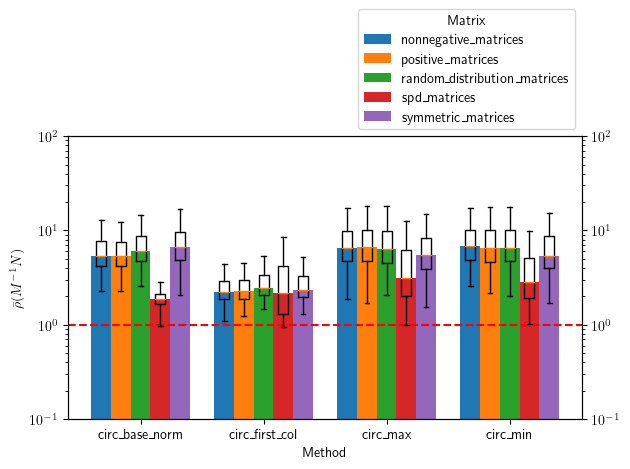

In [208]:
fig, ax = plt.subplots()

ax2 = ax.twinx()
# Number of matrix types
num_matrix_types = len(pivot_df.columns)
# Width of each bar
bar_width = 0.8 / num_matrix_types
# Iterate over each matrix type to plot
for i, matrix_type in enumerate(pivot_df.columns):
    # Compute the positions for the bars
    bar_positions = np.arange(len(pivot_df)) + i * bar_width

    # Plotting
    ax.bar(bar_positions, pivot_df[matrix_type], width=bar_width, label=matrix_type)
    # ax.boxplot
    for j, method in enumerate(pivot_df.index):
        # Fetching the position for the current box plot
        box_pos = bar_positions[j]
        # Fetching the corresponding 'rho' values from boxplots dictionary
        if (matrix_type, method) in boxplots:
            rho_values = boxplots[(matrix_type, method)]
            # Adding a box plot for this specific data
            ax2.boxplot(rho_values, positions=[box_pos], widths=bar_width/2, manage_ticks=False, showfliers=False, meanline=True)

# Adjusting the x-axis to correctly align labels in the center of the group
ax.set_xticks(np.arange(len(pivot_df)) + bar_width * (num_matrix_types - 1) / 2)
ax.set_xticklabels(pivot_df.index)

# Other plot settings
plt.rcParams['text.usetex'] = True
ax.axhline(y=1, color='r', linestyle='--')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_ylim(.1,100)
ax2.set_ylim(.1,100)
ax.set_xlabel('Method')
ax.set_ylabel(r'$\bar{\rho}({M}^{-1}N)$')
# ax.set_title(r'$\bar{\rho}({M}^{-1}N)$ by Method for each Matrix Type')
ax.legend(title='Matrix', loc='lower right', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


0.8653626672397958


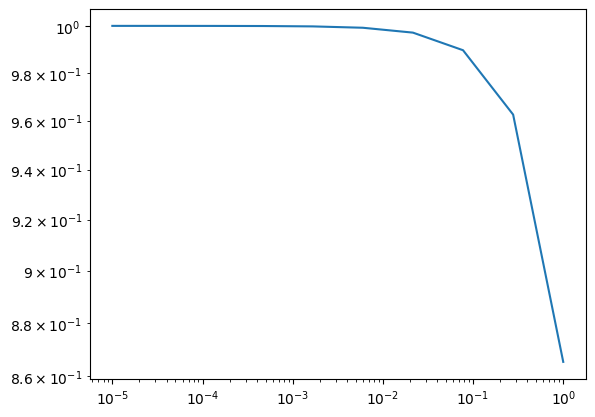

In [36]:
# Investigate SOR parameter omega on the spectral radius

n = 4
# A = np.random.randint(5, size=(n, n))
A = np.random.rand(n, n)
A = A.T @ A
# Calculate how close it is to circulant
omegas = np.logspace(-5, 0, 10)
spectral = []
for omega in omegas:
    c = circ_base_norm(A, omega)
    # print(f"Circulant Basis: {d}")

    M = sp.linalg.circulant(c).T
    N = M - A

    Minv = np.linalg.inv(M)
    G = Minv @ N
    d, v = np.linalg.eig(G)

    spectral.append(np.max(np.abs(d)))

print(np.min(spectral))
omega = np.argmin(spectral)
c = circ_base_norm(A, omegas[omega])
plt.loglog(omegas, spectral)

In [370]:
# Investigate making top row the circulant matrix

n = 4
spectral = 2
ctr = 0
while (spectral > 1) and (ctr <= 1000):
    # flag = True
    # while flag:
    #     flag=False
        # A = np.random.randint(5, size=(n, n))
    A = np.random.rand(n, n)
    # A = A.T @ A
    # Calculate how close it is to circulant
    # c = circ_first_col(A)
    c = circ_max_min(A)
    # print(f"Circulant Basis: {d}")

    M = sp.linalg.circulant(c).T
    N = M - A

    Minv = np.linalg.inv(M)
    G = Minv @ N
    d, v = np.linalg.eig(G)

    spectral = np.max(np.abs(d))
    ctr+=1

U, S, Vh = np.linalg.svd(N)
U = U @ np.diag(S)
uvt = U @ Vh
print(uvt)
print(N)

da, va = d, v = np.linalg.eig(Vh @ Minv @ U)
print(np.max(np.abs(da)))
print(np.min(spectral))
# print(c)
# print(np.argmin(spectral))
# plt.loglog(omegas, spectral)

[[-0.4  0.1 -0.1  0.6]
 [-0.   0.1 -0.4 -0.3]
 [-0.7  0.3 -0.5  0.3]
 [-0.4 -0.1 -0.1 -0.7]]
[[-0.4  0.1 -0.1  0.6]
 [-0.   0.1 -0.4 -0.3]
 [-0.7  0.3 -0.5  0.3]
 [-0.4 -0.1 -0.1 -0.7]]
0.8926142457898658
0.8926142457898667


[[ 0.4  0.2 -0.6 -0.3]
 [-0.9  0.3 -0.5  0.1]
 [-0.4 -0.4  0.3 -0.9]
 [-0.   0.   0.1  1. ]]
[-0.3+0.j   0.8+0.3j  0.8-0.3j  0.7+0.j ]
0.8926142457898667
[[  0.5   1.1  -0.8   7. ]
 [ -1.6   0.3   1.4  -0.1]
 [  0.9  -0.4   0.  -10.3]
 [ -0.2  -0.6   1.2   5. ]]
M Norm: 2.060788405768451
Minv Norm: 3.501144488170144
N Norm: 1.5516330206024256
Minv N Norm: 5.432491397744974
G Norm: 1.9541226971347294
[[0.2 0.4 0.3 0.9]
 [0.9 0.2 0.4 0.3]
 [0.3 0.9 0.2 0.4]
 [0.4 0.3 0.9 0.2]]


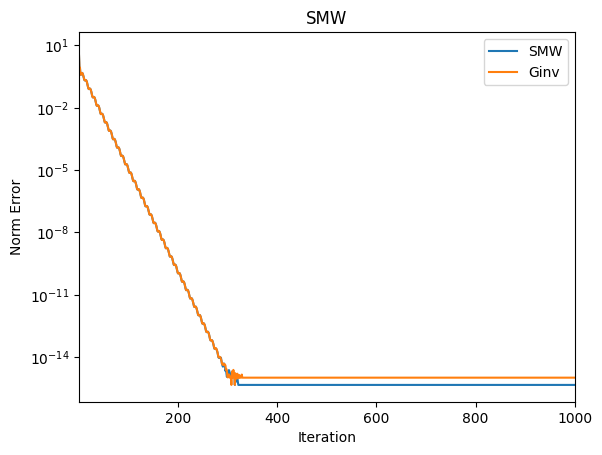

In [371]:
# Generate A
n = 4
# A = np.random.randint(5, size=(n, n))
# A = np.random.rand(n, n)
# A = A.T @ A
# Calculate how close it is to circulant
# omega = omegas[8]
# Q = np.diag(np.ones(n-1), 1) + np.diag(np.ones(1), 1-n)
# d = [1/omega * np.trace(A.T @ np.linalg.matrix_power(Q,i))/n for i in range(1, n+1)]
# c = [c[(i-1) % n] for i in range(n)]
# print(f"Circulant Basis: {d}")
M = sp.linalg.circulant(c).T
N = M - A

# Case 1
b = np.random.randint(1, 5, (4, 1))
xexact = np.linalg.solve(A, b)

# # print(b)

# initialize
err = 1.0
iters = 0
xhist = []
err = []
x = [np.zeros(shape=(4,1))]

Minv = np.linalg.inv(M)
f = Minv @ b
G = Minv @ N
print(G)
d, v = np.linalg.eig(G)
print(d)
print(np.max(np.abs(d)))

niter = 1000
for i in range(niter):
    x.append(G @ x[-1] + f)

Gsum = np.zeros((4,4))
for k in range(10):
    Gsum += np.linalg.matrix_power(G, k)

print(Gsum)

x_smw = np.zeros(shape=(4,1))
# iterate
for i in range(niter):
    g = N @ x_smw + b
    xnew = spl.solve_circulant(M[:,0],g) ### This was previously M[0] which is WRONG
    xhist.append(xnew)
    err.append(npl.norm(A @ xnew - b))
    x_smw = np.copy(xnew)

print(f"M Norm: {np.linalg.norm(M)}")
print(f"Minv Norm: {np.linalg.norm(Minv)}")
print(f"N Norm: {np.linalg.norm(N)}")
print(f"Minv N Norm: {np.linalg.norm(Minv) * np.linalg.norm(N) }")
print(f"G Norm: {np.linalg.norm(G)}")
# print(f"Minv bound: {np.linalg.norm(M - np.eye(n))}")

# # plot
plt.semilogy(range(1,len(xhist)+1), err, label="SMW")
plt.xlabel("Iteration")
plt.ylabel("Norm Error")
plt.xlim(1, len(xhist))
plt.title("SMW")

plt.semilogy([np.linalg.norm(A @ i - b) for i in x], label="Ginv")
plt.legend()
# plt.plot(x)
print(M)

In [8]:
# print(A)
# print(M)
# print(N)
print(G)
Gsum = np.zeros((4,4))
for k in range(10):
    Gsum += np.linalg.matrix_power(G, k)

print(Gsum)

[[-0.44578356 -0.40907908 -0.33483063  0.37948245]
 [ 0.23890635  0.04843637  0.73471023  0.24086288]
 [ 0.4066216   0.63655671 -0.39837261 -0.75746128]
 [-0.29501009 -0.41697132 -0.18280923 -0.15216669]]
[[ 0.40006267 -0.61035862 -0.46192522  0.29699889]
 [ 0.37320167  1.27335645  0.60596585  0.04324638]
 [ 0.45217445  0.62370914  0.9532655  -0.40328682]
 [-0.30882625 -0.4043662  -0.24115468  0.85526167]]


[[-0.3  0.   0.  -0.3]
 [-0.   0.   0.  -0. ]
 [ 0.2  0.   0.   0.2]
 [-0.   0.   0.  -0. ]]
[ 0.   0.  -0.4  0. ]
0.35000000000000003
M Norm: 10.954451150103322
Minv Norm: 0.714142842854285
N Norm: 2.0
Minv N Norm: 1.42828568570857
G Norm: 0.5196152422706632


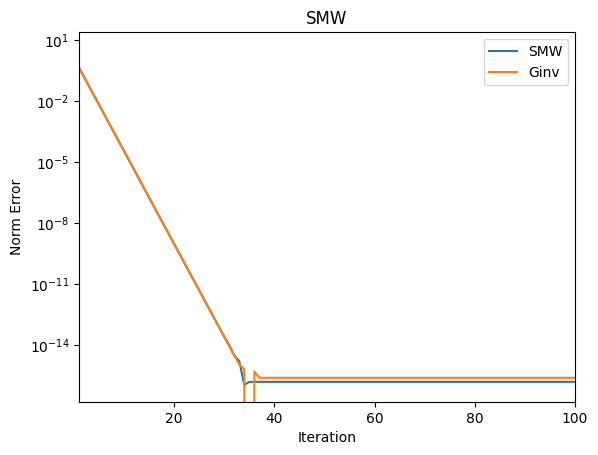

In [305]:
# Generate A
A =  np.array([[5.,3.,2.,2.],
               [1.,4.,3.,2.],
               [2.,1.,4.,3.],
               [4.,2.,1.,5.]])

N = sps.lil_matrix((4, 4))
N[0,0]=-1.0; N[3,0]=-1.0; N[0,3]=-1.0; N[3,3]=-1.0
N = N.toarray()
M = A + N

# Case 1
b = np.random.randint(1, 5, (4, 1))
xexact = np.linalg.solve(A, b)

# # print(b)

# initialize
err = 1.0
iters = 0
xhist = []
err = []
x = [np.zeros(shape=(4,1))]

Minv = np.linalg.inv(M)
f = Minv @ b
G = Minv @ N
print(G)
d, v = np.linalg.eig(G)
print(d)
print(np.max(np.abs(d)))

niter = 100
for i in range(niter):
    x.append(G @ x[-1] + f)

x_smw = np.zeros(shape=(4,1))
# iterate
for i in range(niter):
    c = N @ x_smw + b
    xnew = spl.solve_circulant(M[:,0],c) ### This was previously M[0] which is WRONG
    xhist.append(xnew)
    err.append(npl.norm(A @ xnew - b))
    x_smw = np.copy(xnew)

print(f"M Norm: {np.linalg.norm(M)}")
print(f"Minv Norm: {np.linalg.norm(Minv)}")
print(f"N Norm: {np.linalg.norm(N)}")
print(f"Minv N Norm: {np.linalg.norm(Minv) * np.linalg.norm(N) }")
print(f"G Norm: {np.linalg.norm(G)}")
# print(f"Minv bound: {np.linalg.norm(M - np.eye(n))}")

# # plot
plt.semilogy(range(1,len(xhist)+1), err, label="SMW")
plt.xlabel("Iteration")
plt.ylabel("Norm Error")
plt.xlim(1, len(xhist))
plt.title("SMW")

plt.semilogy([np.linalg.norm(A @ i - b) for i in x], label="Ginv")
plt.legend()
# plt.plot(x)

[[ 0.5  0.   0.   0.5]
 [ 0.   0.   0.   0. ]
 [-1.1  0.   0.  -1.1]
 [-0.6  0.   0.  -0.6]]
[ 0.   0.   0.  -0.1]
0.08055783092397206
M Norm: 2.1527334263703017
Minv Norm: 159.3140916787671
N Norm: 2.0
Minv N Norm: 318.6281833575342
G Norm: 1.8262829960249538


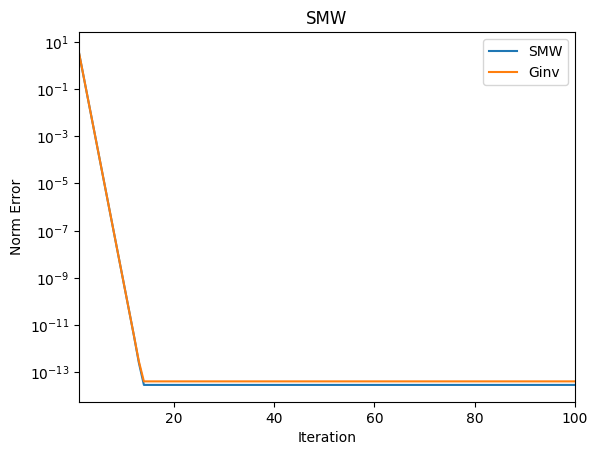

In [291]:
# Generate A
# A =  np.array([[5.,3.,2.,2.],
#                [1.,4.,3.,2.],
#                [2.,1.,4.,3.],
#                [4.,2.,1.,5.]])

M = sp.linalg.circulant(np.random.rand(4))

N = sps.lil_matrix((4, 4))
N[0,0]=-1.0; N[3,0]=-1.0; N[0,3]=-1.0; N[3,3]=-1.0
N = N.toarray()

A = M - N


# Case 1
b = np.random.randint(1, 5, (4, 1))
xexact = np.linalg.solve(A, b)

# # print(b)

# initialize
err = 1.0
iters = 0
xhist = []
err = []
x = [np.zeros(shape=(4,1))]

Minv = np.linalg.inv(M)
f = Minv @ b
G = Minv @ N
print(G)
d, v = np.linalg.eig(G)
print(d)
print(np.max(np.abs(d)))

niter = 100
for i in range(niter):
    x.append(G @ x[-1] + f)


x_smw = np.zeros(shape=(4,1))
# iterate
for i in range(niter):
    c = N @ x_smw + b
    xnew = spl.solve_circulant(M[:,0],c) ### This was previously M[0] which is WRONG
    xhist.append(xnew)
    err.append(npl.norm(A @ xnew - b))
    x_smw = np.copy(xnew)

print(f"M Norm: {np.linalg.norm(M)}")
print(f"Minv Norm: {np.linalg.norm(Minv)}")
print(f"N Norm: {np.linalg.norm(N)}")
print(f"Minv N Norm: {np.linalg.norm(Minv) * np.linalg.norm(N) }")
print(f"G Norm: {np.linalg.norm(G)}")
# print(f"Minv bound: {np.linalg.norm(M - np.eye(n))}")

# # plot
plt.semilogy(range(1,len(xhist)+1), err, label="SMW")
plt.xlabel("Iteration")
plt.ylabel("Norm Error")
plt.xlim(1, len(xhist))
plt.title("SMW")

plt.semilogy([np.linalg.norm(A @ i - b) for i in x], label="Ginv")
plt.legend()
# plt.plot(x)

In [176]:
# Investigate making top row the circulant matrix

n = 4
spectral = 2
ctr = 0
# while (spectral > 1) and (ctr <= 1000):
#     # flag = True
#     # while flag:
#     #     flag=False
#         # A = np.random.randint(5, size=(n, n))
#     A = np.random.rand(n, n)
#     # A = A.T @ A
#     # Calculate how close it is to circulant
#     c = circ_first_col(A)
#     # c = circ_max_min(A)
#     # print(f"Circulant Basis: {d}")

c0 = np.random.rand(1)[0]
c2 = c1 = np.random.rand(1)[0]

c = np.array([c0, c1, -1, c2])+1

M = sp.linalg.circulant(c)

N = np.zeros(shape=(4,4))
N[0,0]=1.0; N[3,0]=1.0; N[0,3]=1.0; N[3,3]=1.0
A = M - N

print(c)
print(A)
print(M)
print(N)


Minv = np.linalg.inv(M)
G = Minv @ N
d, v = np.linalg.eig(G)

spectral = np.max(np.abs(d))


U, S, Vh = np.linalg.svd(N)
U = U @ np.diag(S)
uvt = U @ Vh
print(uvt)
print(N)

da, va = d, v = np.linalg.eig(Vh @ Minv @ U)
print(np.max(np.abs(da)))
print(np.min(spectral))
# print(c)
# print(np.argmin(spectral))
# plt.loglog(omegas, spectral)



[1.77908385 1.59450718 0.         1.59450718]
[[0.77908385 1.59450718 0.         0.59450718]
 [1.59450718 1.77908385 1.59450718 0.        ]
 [0.         1.59450718 1.77908385 1.59450718]
 [0.59450718 0.         1.59450718 0.77908385]]
[[1.77908385 1.59450718 0.         1.59450718]
 [1.59450718 1.77908385 1.59450718 0.        ]
 [0.         1.59450718 1.77908385 1.59450718]
 [1.59450718 0.         1.59450718 1.77908385]]
[[1. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 1.]]
[[1. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 1.]]
[[1. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 1.]]
0.7633713180343059
0.7633713180343061


In [273]:
# Define circulant matrix with form [c0, c1, 0, c1]
n = 4
c0 = np.random.rand(1)[0]
c2 = c1 = np.random.rand(1)[0]
c = np.array([c0, c1, -1, c2])+1
M = sp.linalg.circulant(c)
print(M)

# Make rank 2 matrix N
N = np.zeros(shape=(n, n))
a = 1
N[0,0]=a; N[3,0]=a; N[0,3]=a; N[3,3]=a
A = M - N

# Make DFT Matrix
F = np.zeros((n,n), dtype=complex)
for i in range(n):
    for j in range(n):
        F[i, j] = 1/np.sqrt(n) * np.exp(-2 * np.pi * 1j * i * j / n)

# Recreate the diagonal entries of Minv
D = np.diag(fft(c))
print(F @ np.linalg.inv(D) @ np.linalg.inv(F) @ N)
# Minv = np.linalg.inv(M)
# print(Minv @ N)

# d, v = np.linalg.eig(np.linalg.inv(M) @ N)
# print(d)

# Recreate Finv @ N
Finv = np.linalg.inv(F)
FinvN = np.zeros(shape=(n,n), dtype=complex)
for j in range(n):
    FinvN[j,0] = FinvN[j,n-1] = a/np.sqrt(n) * (1 + np.exp(1j * 2 * np.pi * j * (n-1)/n))
# print(Finv @ N)
# print(FinvN)

Dinv = np.linalg.inv(D)
DFinvN = np.zeros(shape=(n,n), dtype=complex)
for j in range(n):
    DFinvN[j,0] = DFinvN[j,n-1] = a/np.sqrt(n) * 1/D[j,j] * (1 + np.exp(1j * 2 * np.pi * j * (n-1)/n))
# print(DFinvN)
# print(np.linalg.inv(D) @ np.linalg.inv(F) @ N)
# print(np.linalg.norm(DFinvN - np.linalg.inv(D) @ np.linalg.inv(F) @ N))


# # Recreate Minv N
Minv = np.linalg.inv(M)
G = np.zeros(shape=(n,n))
for j in range(n):
    # print((2 + 2 * np.cos(2 * np.pi * j * (n-1)/n)))
    G[j,0] = G[j,n-1] = a/n * 1/D[j,j] * (2 + 2 * np.cos(2 * np.pi * j * (n-1)/n))
print(Minv @ N)
print(G)
print(np.linalg.norm(G - Minv @ N))

np.set_printoptions(precision=1)

[[1.9 1.4 0.  1.4]
 [1.4 1.9 1.4 0. ]
 [0.  1.4 1.9 1.4]
 [1.4 0.  1.4 1.9]]
[[ 0.4-1.0e-16j  0. +0.0e+00j  0. +0.0e+00j  0.4-1.0e-16j]
 [-0.2+1.2e-16j  0. +0.0e+00j  0. +0.0e+00j -0.2+1.2e-16j]
 [-0.2-8.3e-17j  0. +0.0e+00j  0. +0.0e+00j -0.2-8.3e-17j]
 [ 0.4+3.9e-17j  0. +0.0e+00j  0. +0.0e+00j  0.4+3.9e-17j]]
[[ 0.4  0.   0.   0.4]
 [-0.2  0.   0.  -0.2]
 [-0.2  0.   0.  -0.2]
 [ 0.4  0.   0.   0.4]]
[[0.2 0.  0.  0.2]
 [0.3 0.  0.  0.3]
 [0.  0.  0.  0. ]
 [0.3 0.  0.  0.3]]
0.710112375813154


/tmp/ipykernel_5160/1048253342.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  G[j,0] = G[j,n-1] = a/n * 1/D[j,j] * (2 + 2 * np.cos(2 * np.pi * j * (n-1)/n))
